# Probabilistic K-nearest Neighbours (PKNN)

In [ ]:
import jax
import chex
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

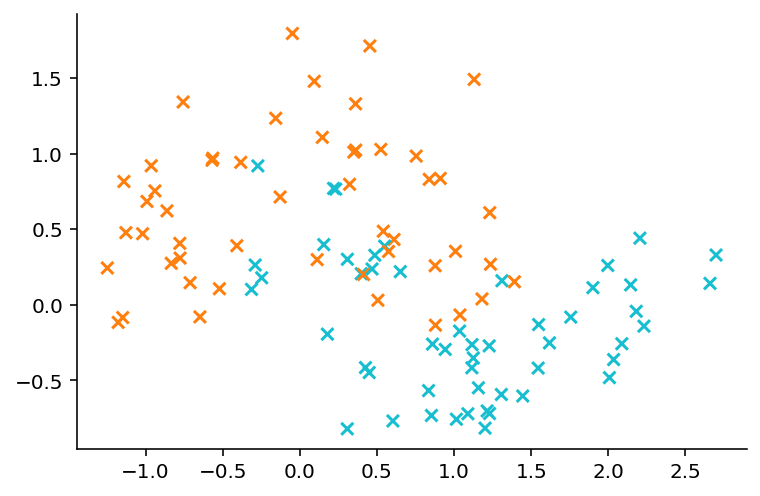

In [6]:
noise = 0.3
X, y = make_moons(101, noise=noise, random_state=314)
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]
plt.scatter(*X.T, c=colors, marker="x")


## Plain-vanilla K-nearest neighbours

In [10]:
def knn(x, X, Y, k):
    """
    Classify an input x based on
    its k closest nearest neighbours
    
    Parameters
    ----------
    x: jnp.array(M,)
        Test observation
    X: jnp.array(N, M)
        Train features
    y: jnp.array(N,)
        Train covariates
    """
    N, _ = X.shape
    mask = jnp.arange(N) < k
    
    distances = jnp.linalg.norm(x - X, axis=1)
    nearest = jnp.argsort(distances)
    
    Y_pred = jnp.take(Y, nearest) * mask
    return Y_pred.sum() / k 

In [11]:
k = 3
knn_vmap = jax.vmap(knn, (1, None, None, None), out_axes=0)
knn_vmap = jax.vmap(knn_vmap, (2, None, None, None), out_axes=1)
knn_vmap_k = jax.vmap(knn_vmap, (None, None, None, 0), out_axes=0)

In [12]:
# steps = 50j
steps = 0.009
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
grid = jnp.mgrid[xmin:xmax:steps, ymin:ymax:steps]
k_values = jnp.array([1, 3, 6, 12])

k_distances_grid = knn_vmap_k(grid, X, y, k_values)

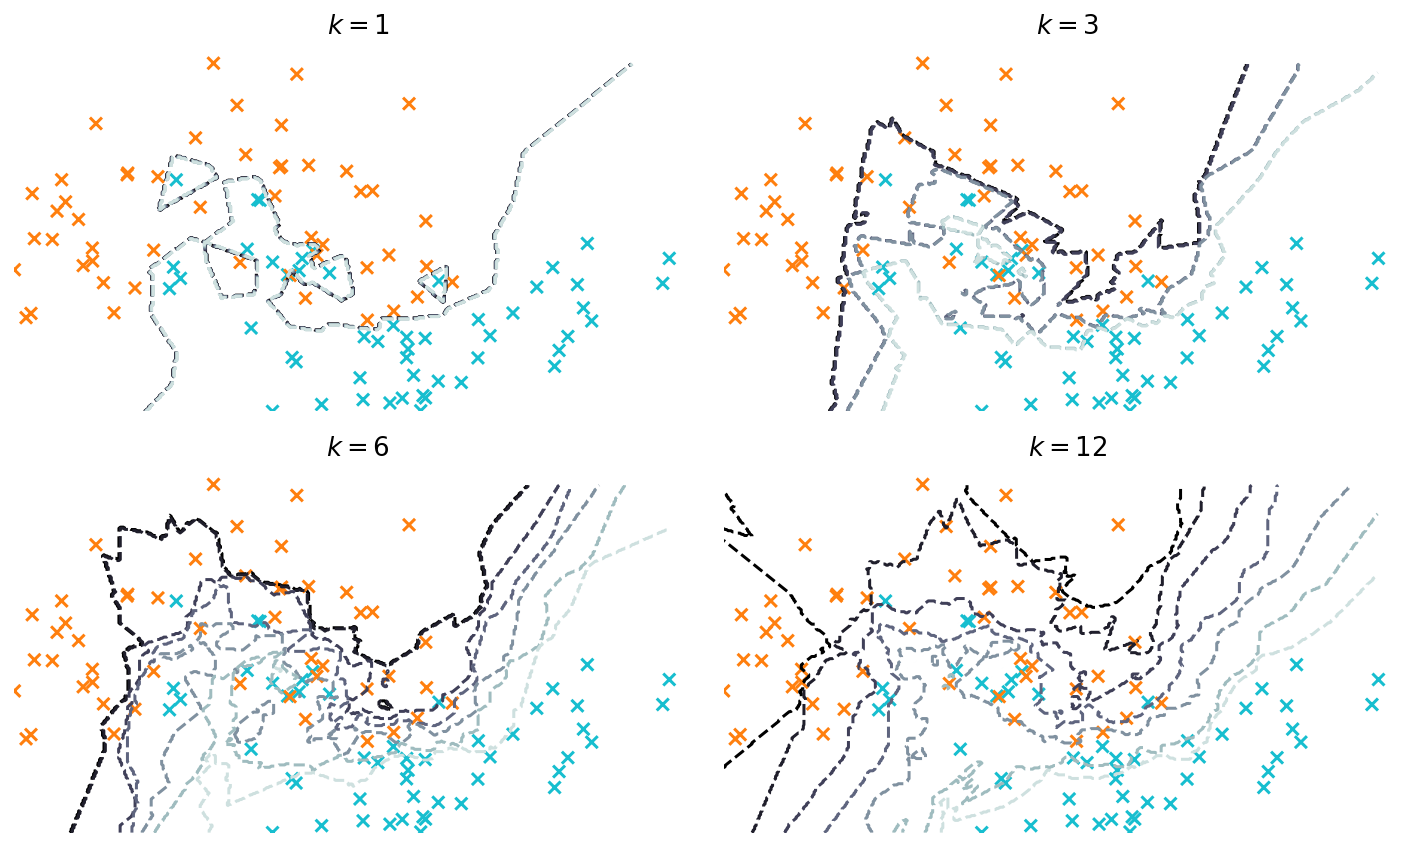

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, k, dgrid in zip(ax, k_values, k_distances_grid):    
    axi.axis("off")
    axi.contour(*grid, dgrid, cmap="bone", linestyles="--")
    axi.set_title(f"$k={k}$", fontsize=13)
    axi.scatter(*X.T, c=colors, marker="x")
plt.tight_layout()
plt.savefig("02-pknn.png", dpi=150)

## Probabilistic KNN

$$
p(y_i \vert {\bf x}, \beta, k) = \frac{\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = y_i)\right)}{\sum_{q=1}^Q\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = q)\right)}
$$

In [33]:
def knn_term(x, y, X, Y, k, beta):
    N, _ = X.shape
    mask = jnp.arange(N)
    mask = (mask <= k) * (mask > 0)
    
    distances = jnp.linalg.norm(x - X, axis=1) ** 2
    nearest = jnp.argsort(distances)
    
    Y_pred = (jnp.take(Y, nearest) == y) * mask
    dist = beta / k * Y_pred.sum()
    return jnp.exp(dist)

knn_term_vmap = jax.vmap(knn_term, (0, 0, None, None, None, None))
knn_term_classes_vmap = jax.vmap(knn_term, (0, None, None, None, None, None))
knn_term_classes_vmap = jax.vmap(knn_term_classes_vmap, (None, 0, None, None, None, None))

In [34]:
k = 6
beta = 0.1
Q = 2
noise = 0.3
classes = jnp.array([0, 1])

In [35]:
X_cv, y_cv = make_moons(20, noise=noise, random_state=271)

x_test = jnp.array([0, 0.5])

In [36]:
unnorm_prob = knn_term_classes_vmap(X_cv, classes, X_cv, y_cv, k, beta)

N, _ = X_cv.shape
normalisation = unnorm_prob.sum(axis=0)
unnorm_prob = unnorm_prob[y_cv, jnp.arange(N)]

likelihood = unnorm_prob / normalisation
likelihood

DeviceArray([0.5083321 , 0.51665986, 0.5083321 , 0.5083321 , 0.51665986,
             0.51665986, 0.4916679 , 0.48334005, 0.51665986, 0.5083321 ,
             0.51665986, 0.5083321 , 0.5083321 , 0.5083321 , 0.5083321 ,
             0.5083321 , 0.4916679 , 0.4916679 , 0.5083321 , 0.5       ],            dtype=float32)

In [37]:
def compute_likelihood(X, y, k, beta):
    N, _ = X.shape
    unnorm_prob = knn_term_classes_vmap(X, classes, X, y, k, beta)
    
    normalisation = unnorm_prob.sum(axis=0)
    unnorm_prob = unnorm_prob[y, jnp.arange(N)]

    likelihood = unnorm_prob / normalisation

    
    return jnp.prod(likelihood)

In [38]:
compute_likelihood(X_cv, y_cv, k, beta)

DeviceArray(1.2182519e-06, dtype=float32)

## Sampling

In [42]:
k_vals = jnp.arange(-4, 5)

def compute_log_likelihood(X, y, k, beta):
    N, _ = X.shape
    unnorm_prob = knn_term_classes_vmap(X, classes, X, y, k, beta)
    
    normalisation = unnorm_prob.sum(axis=0)
    unnorm_prob = unnorm_prob[y, jnp.arange(N)]

    log_likelihood = jnp.log(unnorm_prob) - jnp.log(normalisation)

    
    return jnp.sum(log_likelihood)

def knn_mcmc_step(key, state, X, y, eta):
    N, _ = X.shape
    k, beta, count_acc = state
    
    key_beta, key_k, key_accept = jax.random.split(key, 3)
    
    delta_beta = jax.random.normal(key_beta)
    delta_k = jax.random.choice(key_k, k_vals)
    
    k_hat = jnp.clip(k + delta_k, 1, 100)
    beta_hat = jnp.abs(beta + delta_beta * eta)
    
    logL_hat = compute_log_likelihood(X, y, k_hat, beta_hat)
    logL = compute_log_likelihood(X, y, k, beta)
    
    A = jnp.minimum(1, jnp.exp(logL_hat - logL))
    acc = jax.random.bernoulli(key_accept, p=A)
    k, beta, acc = jax.lax.cond(acc, lambda: (k_hat, beta_hat, 1),
                                     lambda: (k, beta, 0))
    
    count_acc = count_acc + acc
    res = {
        "k": k,
        "beta": beta,
        "A": A
    }
    return (k, beta, count_acc), res


def knn_mcmc(key_init, k_init, beta_init, X, y, eta, num_steps, num_warmup):
    num_steps = num_warmup + num_steps
    keys_steps = jax.random.split(key_init, num_steps)
    
    knnmcmc_part = partial(knn_mcmc_step, X=X, y=y, eta=eta)
    init_state = (k_init, beta_init, 0)
    (_, _, n_acc), chain = jax.lax.scan(lambda s, k: knnmcmc_part(k, s), init_state, keys_steps)
    
    chain["prop_accepted"] = n_acc / num_steps
    return chain

In [43]:
num_warmup = 1_000
num_steps = 3_000
eta = 1.5
key = jax.random.PRNGKey(3141)
keys = jax.random.split(key, 3)

k_init = jnp.array([1, 30, 2.0])
beta_init = jnp.array([10, 0.01, 2.0])

knn_mcmc_vmap = jax.vmap(knn_mcmc, in_axes=(0, 0, 0, None, None, None, None, None))
chains = knn_mcmc_vmap(keys, k_init, beta_init, X, y, eta, num_steps, num_warmup)

chains["prop_accepted"]

DeviceArray([0.38250002, 0.37050003, 0.37300003], dtype=float32)

In [44]:
chains["k"][:, num_warmup:].mean(axis=1)

DeviceArray([17.935333, 18.594334, 18.274666], dtype=float32)

In [45]:
chains["beta"][:, num_warmup:].mean(axis=1)

DeviceArray([4.273824, 4.294362, 4.269535], dtype=float32)

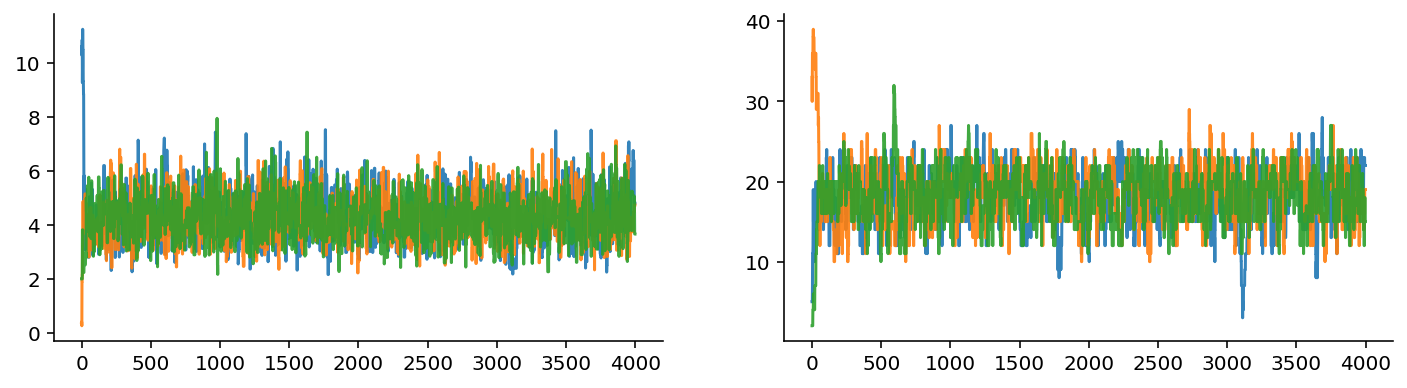

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(chains["beta"].T, alpha=0.9);
ax[1].plot(chains["k"].T, alpha=0.9);

In [47]:
chains_beta = chains["beta"][:, num_warmup:]
chains_k = chains["k"][:, num_warmup:].astype(int)

<AxesSubplot:ylabel='Count'>

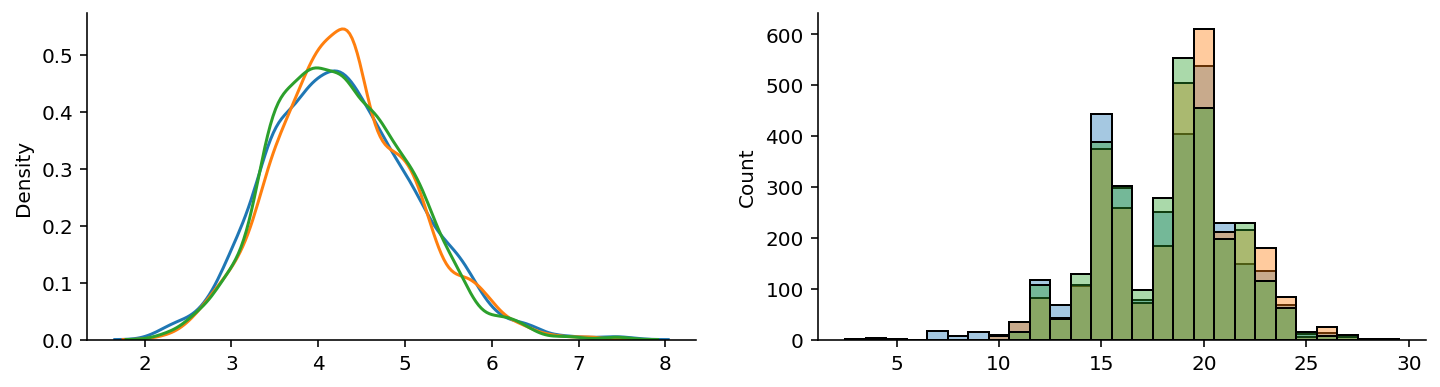

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.kdeplot(chains_beta[0], ax=ax[0])
sns.kdeplot(chains_beta[1], ax=ax[0])
sns.kdeplot(chains_beta[2], ax=ax[0])


sns.histplot(chains_k[0], ax=ax[1], discrete=True, color="tab:blue", alpha=0.4)
sns.histplot(chains_k[1], ax=ax[1], discrete=True, color="tab:orange", alpha=0.4)
sns.histplot(chains_k[2], ax=ax[1], discrete=True, color="tab:green", alpha=0.4)

### The predictive distribution

$$
    p(y_{n+1}\vert {\bf x}_{n+1}, Y, X) \approx \frac{1}{I}\sum_{i=1}^Ip(y_{n + 1}\vert Y, X, \beta^{(i)}, k^{(i)})
$$

In [49]:
def knnexp(x, y, X, Y, k, beta):
    N, _ = X.shape
    mask = jnp.arange(N) < k
    
    distances = jnp.linalg.norm(x - X, axis=1)
    nearest = jnp.argsort(distances)
    
    Y_pred = (jnp.take(Y, nearest) == y) * mask
    dist = beta / k * Y_pred.sum()
    dist = jnp.clip(dist, -30, 30)
    return jnp.exp(dist)

knnexp_vmap = jax.vmap(knnexp, (None, 0, None, None, None, None))


def knn_prob(x, y, X, Y, k, beta):
    unnorm_prob = knnexp_vmap(x, classes, X, Y, k, beta)
    normalisation = unnorm_prob.sum()
    unnorm_prob = unnorm_prob[y]

    prob = unnorm_prob / normalisation
    return prob

knn_prob_posterior = jax.vmap(knn_prob, (None, None, None, None, 0, 0))

In [50]:
knn_prob_posterior_grid = jax.vmap(knn_prob_posterior, (1, None, None, None, None, None), out_axes=0)
knn_prob_posterior_grid = jax.vmap(knn_prob_posterior_grid, (2, None, None, None, None, None), out_axes=1)

In [51]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
step = 0.05
grid = jnp.mgrid[xmin - 0.1:xmax * 1.1:step, ymin - 0.1:ymax * 1.1:step]

In [52]:
k_probs_posterior_grid = knn_prob_posterior_grid(grid, 1, X, y, chains_beta[0], chains_k[0])
k_probs_posterior_mean = k_probs_posterior_grid.mean(axis=-1)
k_probs_posterior_std = k_probs_posterior_grid.std(axis=-1)

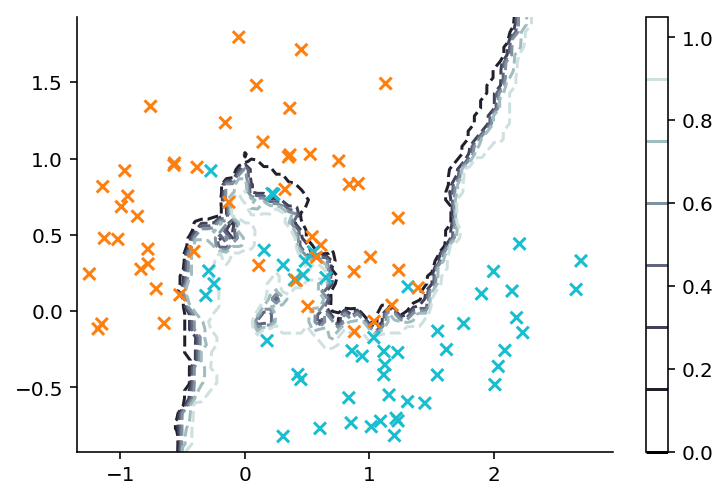

In [56]:
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]
plt.scatter(*X.T, c=colors, marker="x")
plt.contour(*grid, k_probs_posterior_mean, cmap="bone", linestyles="--", zorder=0)
plt.colorbar(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

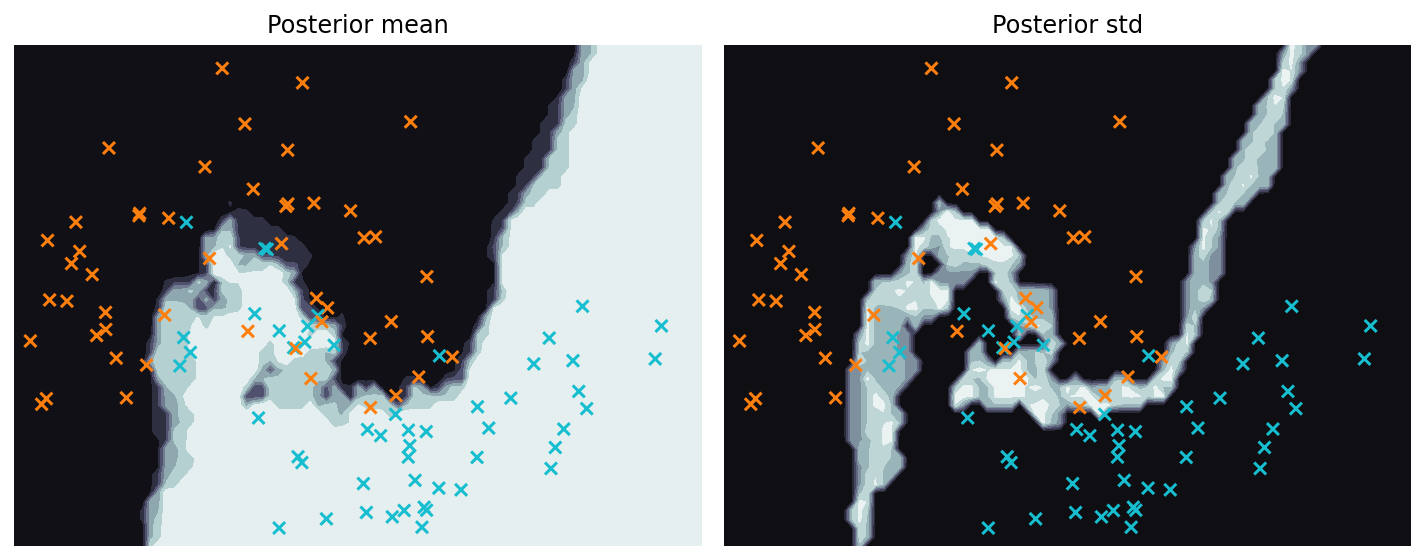

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]


ax[0].scatter(*X.T, c=colors, marker="x")
ax[0].contourf(*grid, k_probs_posterior_mean, cmap="bone", linestyles="--", zorder=0)
ax[0].set_title("Posterior mean")
ax[0].axis("off");

ax[1].set_title("Posterior std")
ax[1].scatter(*X.T, c=colors, marker="x")
ax[1].contourf(*grid, k_probs_posterior_std, cmap="bone", linestyles="--", zorder=0)
ax[1].axis("off");

plt.tight_layout()

# KNN v.s PKNN

## Moon's dataset

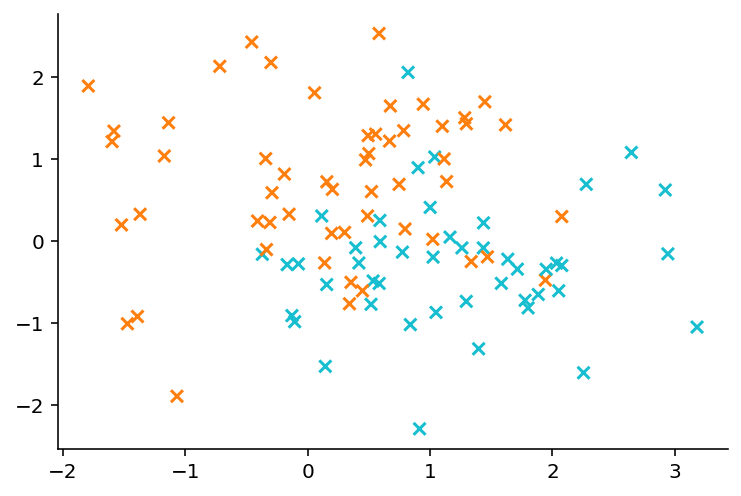

In [58]:
noise = 0.7
n_train = 100
n_test = 100
X, y = make_moons(n_train + n_test, noise=noise, random_state=314)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

colors = ["tab:cyan" if yi else "tab:orange" for yi in y_train]
plt.scatter(*X_train.T, c=colors, marker="x")

### KNN

In [59]:
%%time
k_neighs = np.arange(1, 80)
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": k_neighs}, pre_dispatch=90)
res = knn_gs.fit(X_train, y_train)

CPU times: user 726 ms, sys: 0 ns, total: 726 ms
Wall time: 725 ms


In [60]:
res.best_estimator_, res.best_score_

(KNeighborsClassifier(n_neighbors=15), 0.8)

### PKNN

In [61]:
%%time
num_warmup = 100_000
num_steps = 20_000
eta = 0.9
key = jax.random.PRNGKey(3141)
keys = jax.random.split(key, 2)

k_init = jnp.array([10, 40])
beta_init = jnp.array([1.0, 0.01])

chains = knn_mcmc_vmap(keys, k_init, beta_init, X_train, y_train, eta, num_steps, num_warmup)
chains["prop_accepted"].block_until_ready()

CPU times: user 3.01 s, sys: 103 ms, total: 3.11 s
Wall time: 37.8 s


DeviceArray([0.6228833, 0.6214167], dtype=float32)

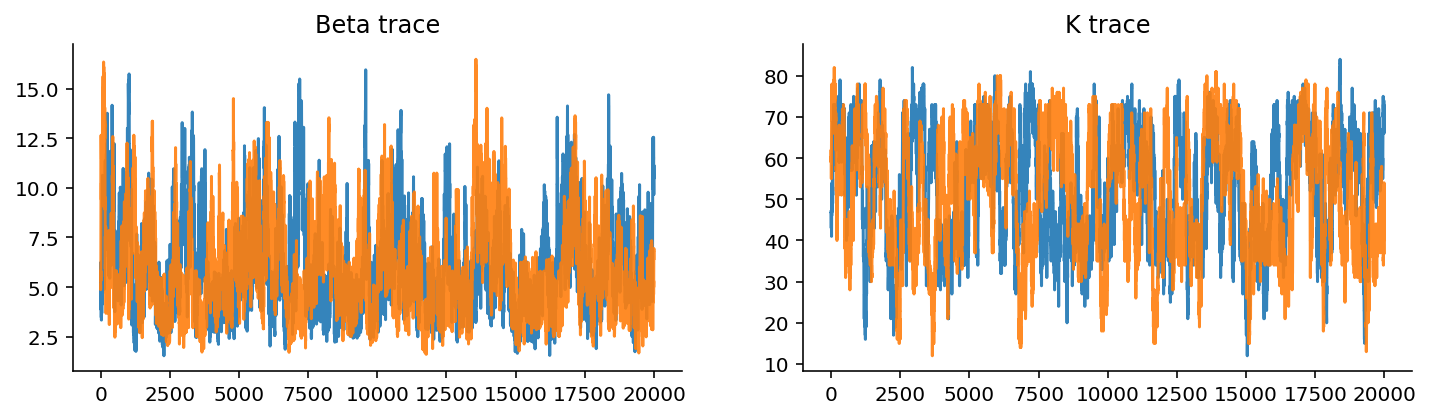

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(chains["beta"].T[num_warmup:], alpha=0.9);
ax[1].plot(chains["k"].T[num_warmup:], alpha=0.9);

ax[0].set_title("Beta trace")
ax[1].set_title("K trace");

In [63]:
chains_beta = chains["beta"][:, num_warmup:]
chains_k = chains["k"][:, num_warmup:].astype(int)

<AxesSubplot:ylabel='Count'>

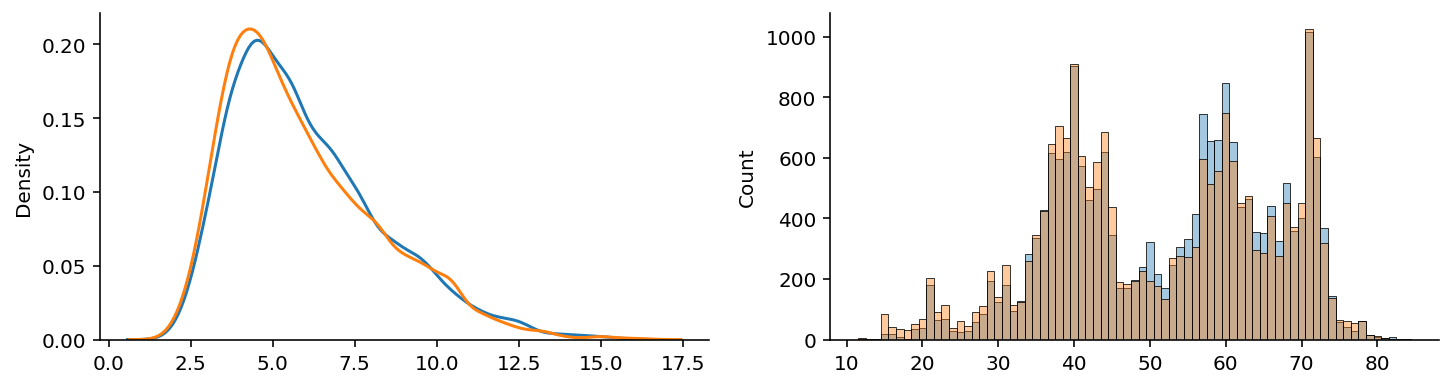

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.kdeplot(chains_beta[0], ax=ax[0])
sns.kdeplot(chains_beta[1], ax=ax[0])


sns.histplot(chains_k[0], ax=ax[1], discrete=True, color="tab:blue", alpha=0.4)
sns.histplot(chains_k[1], ax=ax[1], discrete=True, color="tab:orange", alpha=0.4)

In [65]:
knn_prob_posterior_vmap = jax.vmap(knn_prob_posterior, (0, None, None, None, None, None), out_axes=0)
probs = knn_prob_posterior_vmap(X_test, 1, X_train, y_train, chains_k[1], chains_beta[1])

## Base prediction

In [66]:
yhat_pknn = (probs.mean(axis=1) > 0.5).astype(int)
yhat_knn = knn_gs.predict(X_train)

In [67]:
f1_score(y_test, yhat_knn)

0.5294117647058824

In [68]:
f1_score(y_test, yhat_pknn)

0.6896551724137931

In [69]:
confusion_matrix(y_test, yhat_pknn)

array([[43,  3],
       [24, 30]])

In [70]:
confusion_matrix(y_test, yhat_knn)

array([[25, 21],
       [27, 27]])

## Comparing prediction uncertainty

In [71]:
knn_probs = knn_gs.predict_proba(X_test)
pknn_probs = probs.mean(axis=1)

### Class 1 test

In [72]:
jnp.take(y_test, jnp.where(knn_probs > 0.7)[0]).mean()

DeviceArray(0.46153846, dtype=float32)

In [73]:
jnp.take(y_test, jnp.where(pknn_probs > 0.7)[0]).mean()

DeviceArray(0.9166667, dtype=float32)

### Class 2 test

In [74]:
1 - jnp.take(y_test, jnp.where(knn_probs < 0.3)[0]).mean()

DeviceArray(0.53846157, dtype=float32)

In [75]:
1 - jnp.take(y_test, jnp.where(pknn_probs < 0.3)[0]).mean()

DeviceArray(0.7659575, dtype=float32)

## Orstein-Uhlenbeck (OU) processs

An OU process is given by

$$
    dS_t = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where
* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the stardard deviation of the process


In [76]:
@chex.dataclass
class OUParams:
    kappa: float
    mean: float
    sigma: float

In [77]:
def ou_step(s_prev, key, dt, params):
    noise = jax.random.normal(key)
    s_next = s_prev + params.kappa * (params.mean - s_prev) * dt + jnp.sqrt(dt) * params.sigma * noise
    return s_next, s_next

def simulate_ou(key, s_init, params, T, dt):
    time = jnp.arange(0, T, dt)
    n_steps = len(time)
    keys = jax.random.split(key, n_steps)
    part_ou = partial(ou_step, dt=dt, params=params)
    
    _, simulation = jax.lax.scan(part_ou, s_init, keys)
    return simulation, time

In [78]:
mean = 10.0
params = OUParams(kappa=1.0, mean=mean, sigma=0.1)

In [79]:
key = jax.random.PRNGKey(314)
dt = 0.005
T = 5

n_sims = 8
keys = jax.random.split(key, n_sims)

simulate_ou_pmap = partial(simulate_ou, s_init=10.0, params=params, T=T, dt=dt)
simulate_ou_pmap = jax.pmap(simulate_ou_pmap, in_axes=0)
simulations, time = simulate_ou_pmap(keys)
time = time[0]

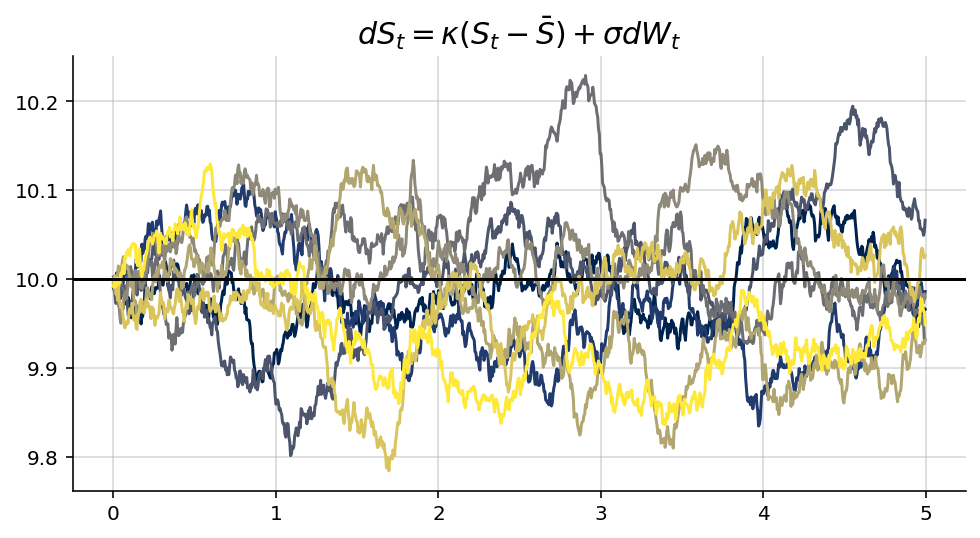

In [80]:
colors = plt.cm.cividis(jnp.linspace(0, 1, n_sims))

fig, ax = plt.subplots(figsize=(8, 4))

for n, simulation in enumerate(simulations):
    plt.plot(time, simulation, c=colors[n])

plt.title(r"$dS_t = \kappa (S_t - \bar S) + \sigma dW_t$", fontsize=15)
plt.axhline(params.mean, c="black")
plt.grid(alpha=0.5)

### Generating training data

In [81]:
def ts_supervised(data, n_in=1, n_out=1):
    """
    Transform a matrix of size TxS to a supervised machine learning
    problem.
    
    n_in: int
        The number of previous steps to consider. This is the
        X matrix of values (x_{t-n_in}, ..., x_{t-1}) as input 
        to the model
        
    n_out: int
        The number of posterior steps to consider. This is a 
        Y matrix of values (y_{t}, y_{t+1}, ..., y_{t+n_out})
        which serves as output to the model
    """
    _, n_vars = data.shape
    base_cols = data.columns
    cols, col_names = [], []
    agg = {}
    # Input sequence (t-n, .., t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        col_names.extend([f"{base_cols[j-1]}(t-{i})"
                          for j in range(1, n_vars + 1)])
    # forecast sequence (t, .., t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        col_names.extend([f"{base_cols[j-1]}(t+{i})".replace("+0", "")
                           for j in range(1, n_vars + 1)])

    agg = pd.concat(cols, axis=1).dropna()
    agg.columns = col_names
    return agg


In [112]:
dt = 0.005
T = 100
simulation, time = simulate_ou(key, 10.0, params, T, dt)
simulation = pd.DataFrame(simulation.to_py(), index=time, columns=["S"])

t_fwd = 50
S = ts_supervised(simulation, 20, t_fwd).iloc[::t_fwd]
S = S.sample(frac=1.0, replace=False, random_state=3141)

n_test = 50

Text(0, 0.5, '$S_t$')

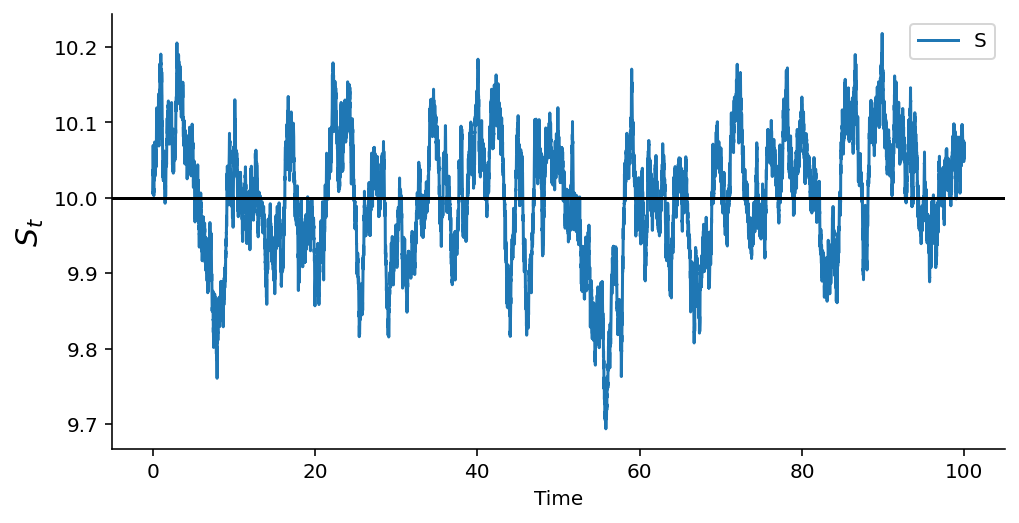

In [113]:
fig, ax = plt.subplots(figsize=(8, 4))
simulation.plot(ax=ax)
plt.axhline(y=mean, c="black")
plt.xlabel("Time")
plt.ylabel("$S_t$", fontsize=15)

In [114]:
y = (S.iloc[:, -1] > mean).values.astype(int)
y = jnp.array(y).astype(int)

In [115]:
X = S.iloc[:, :-t_fwd].values
X = jnp.array(X)

In [116]:
y_test = y[-n_test:]
X_test = X[-n_test:]

X = X[:-n_test]
y = y[:-n_test]

In [117]:
%%time
k_neighs = np.arange(1, 50)
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": k_neighs}, pre_dispatch=90)
knn_gs.fit(X, y)
knn_gs.best_estimator_, knn_gs.best_score_

CPU times: user 2min 45s, sys: 4.12 s, total: 2min 49s
Wall time: 3.49 s


(KNeighborsClassifier(n_neighbors=45), 0.8136645962732919)

In [118]:
k_vals = jnp.arange(-10, 11, 3)

In [119]:
%%time
num_warmup = 10_000
num_steps = 3_000
eta = 1.3
key = jax.random.PRNGKey(3141)
keys = jax.random.split(key, 2)

k_init = jnp.array([2, 50])
beta_init = jnp.array([1.0, 0.01])


knn_mcmc_pmap = partial(knn_mcmc, X=X, y=y, eta=eta, num_steps=num_steps, num_warmup=num_warmup)
knn_mcmc_pmap = jax.vmap(knn_mcmc_pmap, in_axes=(0, 0, 0))

chains = knn_mcmc_pmap(keys, k_init, beta_init)
# chains = knn_mcmc_vmap(keys, k_init, beta_init, X, y, eta, num_steps, num_warmup)

chains["prop_accepted"].block_until_ready()

CPU times: user 3.84 s, sys: 117 ms, total: 3.95 s
Wall time: 43.6 s


DeviceArray([0.16684616, 0.17115384], dtype=float32)

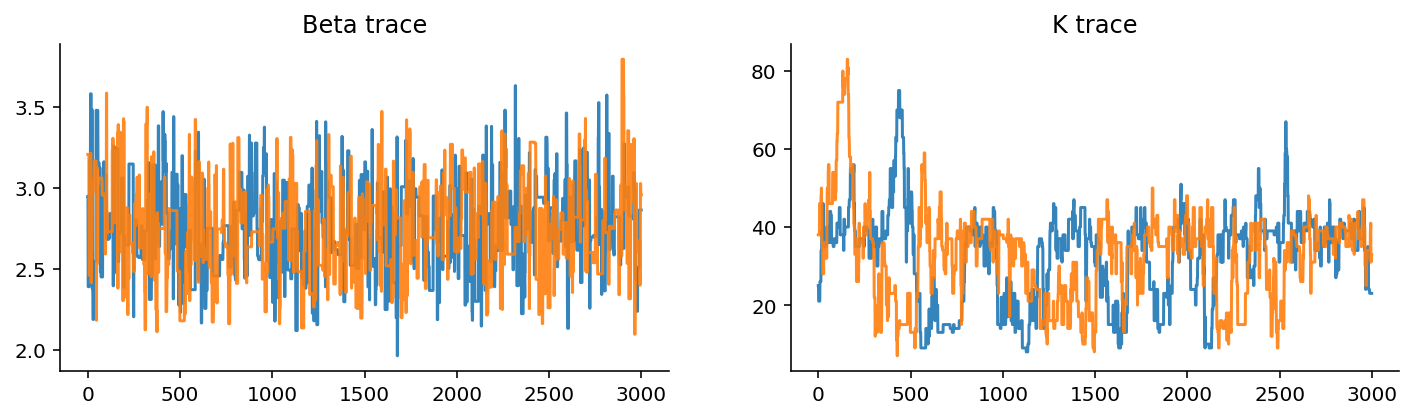

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(chains["beta"].T[num_warmup:], alpha=0.9);
ax[1].plot(chains["k"].T[num_warmup:], alpha=0.9);

ax[0].set_title("Beta trace")
ax[1].set_title("K trace");

In [121]:
chains_beta = chains["beta"][:, num_warmup:]
chains_k = chains["k"][:, num_warmup:].astype(int)

<AxesSubplot:ylabel='Count'>

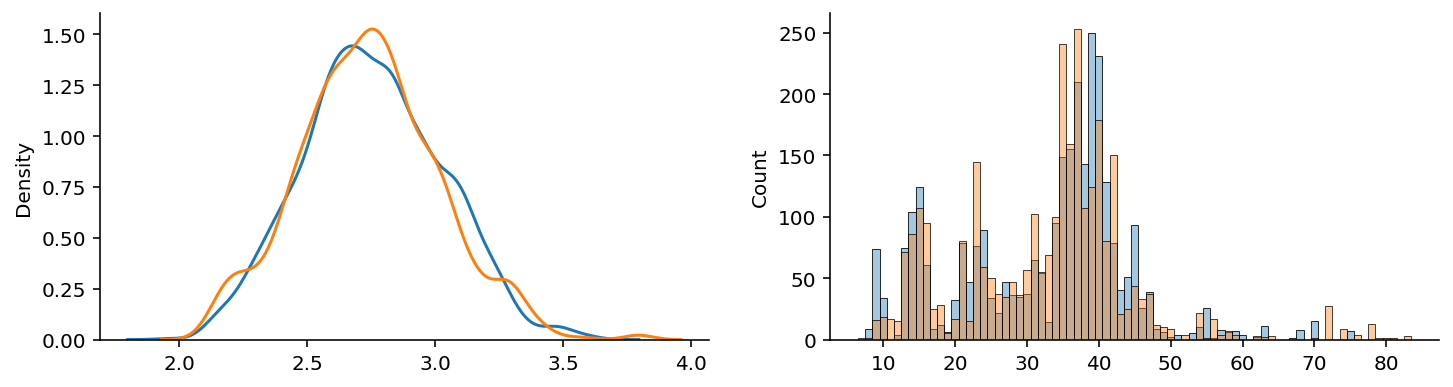

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.kdeplot(chains_beta[0], ax=ax[0])
sns.kdeplot(chains_beta[1], ax=ax[0])


sns.histplot(chains_k[0], ax=ax[1], discrete=True, color="tab:blue", alpha=0.4)
sns.histplot(chains_k[1], ax=ax[1], discrete=True, color="tab:orange", alpha=0.4)

In [124]:
knn_prob_posterior_vmap = jax.vmap(knn_prob_posterior, (0, None, None, None, None, None), out_axes=0)
probs = knn_prob_posterior_vmap(X_test, 1, X, y, chains_k[0], chains_beta[0])

## Base prediction

In [139]:
yhat_pknn = (probs.mean(axis=1) > 0.5).astype(int)
yhat_knn = knn_gs.predict(X_test)

In [140]:
f1_score(y_test, yhat_knn)

0.8148148148148148

In [141]:
f1_score(y_test, yhat_pknn)

0.8148148148148148

In [142]:
confusion_matrix(y_test, yhat_pknn)

array([[18,  3],
       [ 7, 22]])

In [143]:
confusion_matrix(y_test, yhat_knn)

array([[18,  3],
       [ 7, 22]])

## Comparing prediction uncertainty

In [130]:
knn_probs = knn_gs.predict_proba(X_test)
pknn_probs = probs.mean(axis=1)

### Class 1 test

In [131]:
jnp.take(y_test, jnp.where(knn_probs > 0.7)[0]).mean()

DeviceArray(0.61538464, dtype=float32)

In [132]:
jnp.take(y_test, jnp.where(pknn_probs > 0.7)[0]).mean()

DeviceArray(1., dtype=float32)

### Class 2 test

In [133]:
1 - jnp.take(y_test, jnp.where(knn_probs < 0.3)[0]).mean()

DeviceArray(0.38461536, dtype=float32)

In [134]:
1 - jnp.take(y_test, jnp.where(pknn_probs < 0.3)[0]).mean()

DeviceArray(0.6956521, dtype=float32)